# Part 0. Dataset Preparation


In [1]:
from torchtext import data, datasets
import torch
from sklearn.model_selection import train_test_split
import random
import numpy as np
import string
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import os
os.environ["PYTHONHASHSEED"] = str(42)
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:

# For tokenization
TEXT = data.Field(tokenize="spacy", tokenizer_language="en_core_web_sm", include_lengths=True)
# For multi-class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)
# The datasets.TREC class in torchtext is hardcoded to download and parse the full training set (Set 5) and the TREC 10 test set.
# You don’t specify which subset to use — it always loads the largest one by default.
print(vars(train_data.examples[0]))
print("Train size:", len(train_data.examples))



{'text': ['How', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'Russia', '?'], 'label': 'DESC'}
Train size: 5452


In [3]:
# Show some examples

for i in range(10):
    random_index = random.randint(0,len(train_data))
    print(' '.join(train_data.examples[random_index].text), train_data.examples[random_index].label)

What is the most famous German word in the English language ? ENTY
Where are the leading medical groups specializing in lung diseases ? LOC
What actor said in A Day at the Races : ` ` Either he 's dead or my watch has stopped '' ? HUM
Which area produces the least acidic coffee ? LOC
When did Princess Diana and Prince Charles get married ? NUM
What Asian city boasts the world 's biggest bowling alley ? LOC
What is a handheld PC ? DESC
On average , how many miles are there to the moon ? NUM
When was Beethoven born ? NUM
What is the name of the chronic neurological autoimmune disease which attacks the protein sheath that surrounds nerve cells causing a gradual loss of movement in the body ? ENTY


In [4]:

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


trains_data, valid_data = train_data.split(split_ratio=0.8)

In [5]:
# View multiple samples
for i in range(3):  # adjust the range as needed
    print(vars(trains_data.examples[i]))
    

print("Train size (after spliting):", len(trains_data.examples))
print("Validation size:", len(valid_data.examples))
print("Test size:", len(test_data.examples))



{'text': ['What', 'North', 'American', 'city', 'boasts', 'the', 'biggest', 'Polish', 'population', '?'], 'label': 'LOC'}
{'text': ['What', 'celestial', 'body', 'has', 'a', 'diameter', 'of', '864', ',', '000', 'miles', '?'], 'label': 'LOC'}
{'text': ['When', 'did', 'Mount', 'St.', 'Helen', 'last', 'have', 'a', 'significant', 'eruption', '?'], 'label': 'NUM'}
Train size (after spliting): 4362
Validation size: 1090
Test size: 500


#  Part 1. Preparing Word Embeddings


##  Question 1. Word Embedding (glove)

In [6]:
# Tokenizer and Vocabulary with GloVe
TEXT.build_vocab(trains_data, vectors="glove.6B.100d")
LABEL.build_vocab(trains_data)

(a) What is the size of the vocabulary formed from your training data according to your tokeniza
tion method?

In [7]:
#  Check vocabulary size
print(f"Size of TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Size of LABEL vocabulary: {len(LABEL.vocab)}")

Size of TEXT vocabulary: 8138
Size of LABEL vocabulary: 6


(b) We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but
 not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?
 What is the number of OOV words for each topic category?

In [8]:


# Prepare GloVe vocabulary
glove_vocab = set(TEXT.vocab.stoi.keys())

# Track OOV words per label
oov_words_per_label = defaultdict(set)
# Track all OOV words in training data
all_oov_words = set()

# Iterate over training data
for example in trains_data:
    label = example.label
    # Normalize words: lowercase + remove punctuation
    words = [w.lower().strip(string.punctuation) for w in example.text]
    for w in words:
        if w not in glove_vocab:
            oov_words_per_label[label].add(w)
            all_oov_words.add(w)

# Print unique OOV per label
print("Unique OOV words per label:")
for label, words in oov_words_per_label.items():
    print(f"{label}: {len(words)}")

# Total unique OOV in training data
print(f"\nTotal unique OOV words in training data: {len(all_oov_words)}")

# Optional: verify sum matches total
sum_per_label = sum(len(words) for words in oov_words_per_label.values())
print(f"Sum of unique OOVs across labels (with overlaps): {sum_per_label}")


Unique OOV words per label:
LOC: 520
NUM: 462
DESC: 456
ENTY: 690
HUM: 982
ABBR: 53

Total unique OOV words in training data: 2386
Sum of unique OOVs across labels (with overlaps): 3163


 (c) The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove).
 Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you
 think is the best strategy to mitigate such limitation? Implement your solution in your source
 code. Show the corresponding code snippet.

the best strategy: subword averaging + random for frequent OOVs + <unk> for very rare OOVs.
1. Uses GloVe embeddings for known words.

2. For OOV words, tries subword (character n-gram) averaging.
Break the OOV word into character n-grams (e.g., 3–6 letters).
Take embeddings of subwords that exist in the pretrained vocabulary.
Average those subword embeddings to represent the OOV word.

3. Falls back to random vector for frequent OOVs — lets the model learn their meaning
Helps avoid errors, but it does not carry semantic information

4. <unk> vector for rare OOVs — prevents noise from too many low-frequency random vectors

Use Subword Information (FastText-like)

Pros:
- Handles morphological variations (e.g., runner → run) and rare words well.

- Uses known subwords to create a vector → better semantic representation than random vectors.

- No need for additional large datasets; can work with existing embeddings.

In [9]:

embedding_dim = 100
vocab = TEXT.vocab
vectors = vocab.vectors.clone()
glove_vocab = set(vocab.stoi.keys())

# Subword parameters
ngram_min = 3
ngram_max = 6

# Count word frequency in training data
word_counter = Counter()
for example in trains_data:
    word_counter.update([w.lower().strip(string.punctuation) for w in example.text])

# Threshold to consider a word “frequent” (adjustable)
freq_threshold = 3

# <unk> vector
unk_vector = torch.zeros(embedding_dim)

# Counters
subword_count = 0
random_count = 0
unk_count = 0

def get_subwords(word, n_min=3, n_max=6):
    word = f"<{word.lower()}>"
    subwords = []
    for n in range(n_min, n_max+1):
        subwords += [word[i:i+n] for i in range(len(word)-n+1)]
    return subwords

def get_word_vector(word):
    global subword_count, random_count, unk_count
    w_clean = word.lower().strip(string.punctuation)
    
    if w_clean in glove_vocab:
        return vectors[vocab.stoi[w_clean]]
    
    # Subword averaging
    subwords = get_subwords(w_clean, ngram_min, ngram_max)
    subword_vecs = [vectors[vocab.stoi[sg]] for sg in subwords if sg in glove_vocab]
    if subword_vecs:
        subword_count += 1
        return torch.stack(subword_vecs).mean(0)
    
    # Random vector for frequent OOVs
    if word_counter[w_clean] >= freq_threshold:
        random_count += 1
        return torch.randn(embedding_dim)
    
    # <unk> for rare OOVs
    unk_count += 1
    return unk_vector

# Build embedding matrix
embedding_matrix = {}
for example in trains_data:
    for w in example.text:
        if w not in embedding_matrix:
            embedding_matrix[w] = get_word_vector(w)

# Report statistics
total_oov = subword_count + random_count + unk_count
print(f"Total OOV words in training data handled: {total_oov}")
print(f" - Handled by subword averaging: {subword_count}")
print(f" - Handled by random vectors: {random_count}")
print(f" - Handled by <unk> vector: {unk_count}")


Total OOV words in training data handled: 2411
 - Handled by subword averaging: 1079
 - Handled by random vectors: 229
 - Handled by <unk> vector: 1103


 (d) 

(i)  Select the 20 most frequent words from each topic category in the training set (removing
 stopwords if necessary).

In [10]:


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

embedding_dim = 100
vocab = TEXT.vocab
vectors = vocab.vectors.clone()
glove_vocab = set(vocab.stoi.keys())

# Count word frequency per label
label_word_counter = defaultdict(Counter)

for example in trains_data:
    label = example.label
    words = [w.lower().strip(string.punctuation) for w in example.text]
    words = [w for w in words if w and w not in stop_words]  # remove empty strings & stopwords
    label_word_counter[label].update(words)

# Select top 20 words per label
top_words_per_label = {}
for label, counter in label_word_counter.items():
    top_words = [w for w, _ in counter.most_common(20)]
    top_words_per_label[label] = top_words


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yukil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
print(top_words_per_label)

{'LOC': ['country', 'city', 'world', 'state', 'find', 'largest', 'u.s', 'name', 'highest', 'countries', 'capital', 'first', 'get', 'mountain', 'information', 'two', 'located', 'river', 'american', 'america'], 'NUM': ['many', 'year', 'long', 'much', 'people', 'first', 'take', 'average', 'day', 'world', 'american', 'war', 'u.s', 'old', 'population', 'number', 'live', 'years', 'cost', 'date'], 'DESC': ['mean', 'origin', 'get', 'name', 'difference', 'come', 'find', 'word', 'work', 'causes', 'make', 'term', 'meaning', 'someone', 'like', 'say', 'people', 'definition', 'water', 'school'], 'ENTY': ['name', 'fear', 'first', 'film', 'kind', 'called', 'color', 'world', 'used', 'book', 'game', 'best', 'drink', 'movie', 'made', 'war', 'novel', 'play', 'english', 'word'], 'HUM': ['name', 'first', 'president', 'company', 'wrote', 'world', 'u.s', 'famous', 'team', 'two', 'tv', 'baseball', 'invented', 'made', 'portrayed', 'movie', 'actor', 'character', 'show', 'star'], 'ABBR': ['stand', 'abbreviation',

(ii) Retrieve their pretrained embeddings (from Word2Vec or GloVe).
 Project these embeddings into 2D space (using e.g., t-SNE or Principal Component Analysis)

In [12]:

all_words = []
all_embeddings = []
all_labels = []

for label, words in top_words_per_label.items():
    for w in words:
        w_clean = w.lower().strip(string.punctuation)
        if not w_clean:
            continue
        if w_clean not in embedding_matrix:
            continue  # skip words not in embedding_matrix
        emb = embedding_matrix[w_clean]
        all_words.append(w_clean)
        all_embeddings.append(emb.numpy())
        all_labels.append(label)

all_embeddings = torch.tensor(all_embeddings).numpy()


C:\Users\yukil\AppData\Local\Temp\ipykernel_126708\1210675647.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  all_embeddings = torch.tensor(all_embeddings).numpy()


In [13]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
emb_2d = tsne.fit_transform(all_embeddings)


(iii)  Plot the points in a scatter plot, color-coded by their topic category. 

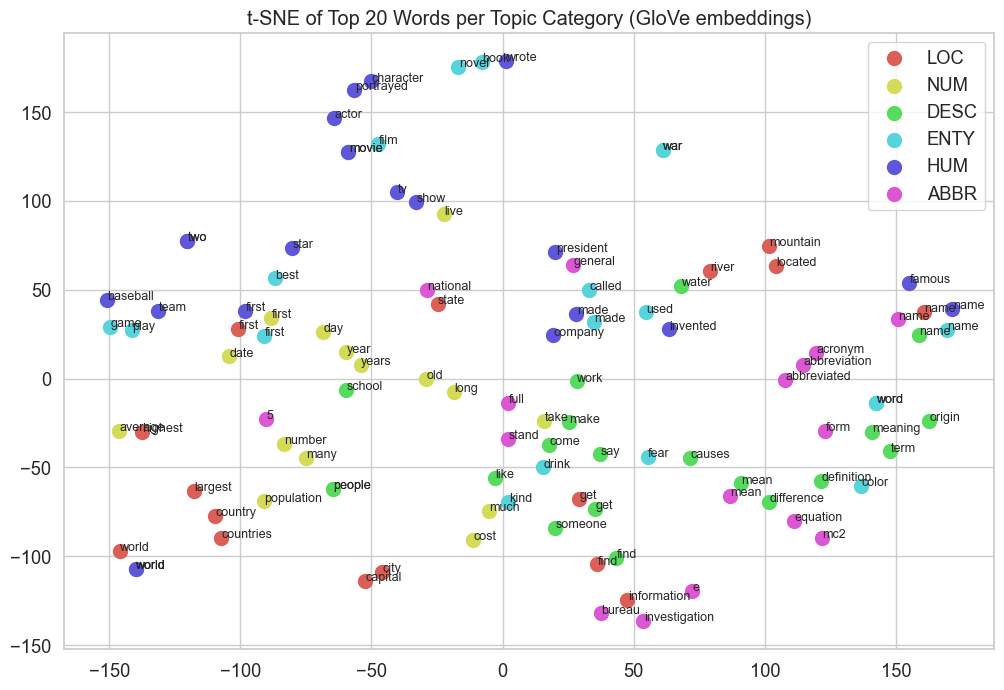

In [14]:

sns.set(style="whitegrid", font_scale=1.2)

# Assign a color per label
unique_labels = list(top_words_per_label.keys())
palette = sns.color_palette("hls", len(unique_labels))
label_color = {label: palette[i] for i, label in enumerate(unique_labels)}

plt.figure(figsize=(12, 8))
for i, label in enumerate(unique_labels):
    idx = [j for j, l in enumerate(all_labels) if l == label]
    plt.scatter(emb_2d[idx,0], emb_2d[idx,1], label=label, color=palette[i], s=100)

# Annotate words
for i, word in enumerate(all_words):
    plt.text(emb_2d[i,0]+0.2, emb_2d[i,1]+0.2, word, fontsize=9)

plt.title("t-SNE of Top 20 Words per Topic Category (GloVe embeddings)")
plt.legend()
plt.show()
